# CPSC 330 - Applied Machine Learning 

## Homework 5: Evaluation metrics
### Associated lectures: [Lectures 9, 10](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Feb 27, 2023 at 11:59pm**

## Imports

In [1]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Instructions 
<hr>
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has cancer or not. It is important to catch this disease early to reduce mortality rate; late diagnosis will result in metastasis to other organs, which adversely impacts patient's prognosis. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|         | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 48 | 32 |
| **Actual no disease**       | 20 | 100 |


- Model B

|        | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 43 | 22 |
| **Actual no disease**       | 35 | 100 |

### 1.1 Positive vs. negative class 
rubric={points:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

Answer:  
"disease" is likely to be the "positive" class, because that is what our model wishes to find.

<br><br>

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [2]:
results_dict = {"A": {}, "B": {}}

In [3]:
results_dict["A"]["accuracy"] = (48+100)/(48+100+20+32)
results_dict["B"]["accuracy"] = (43+100)/(43+100+22+35)
print(results_dict["A"]["accuracy"])
print(results_dict["B"]["accuracy"])

0.74
0.715


<br><br>

### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

Answer:  
Model A, since its accuracy is higher.

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [4]:
A_prec = results_dict["A"]["precision"] = 48/68
B_prec = results_dict["B"]["precision"] = 43/(43+35)
A_recall = results_dict["A"]["recall"] = 48/80
B_recall = results_dict["B"]["recall"] = 43/(43+22)
results_dict["A"]["f1"] = (2*A_prec*A_recall)/(A_prec+A_recall)
results_dict["B"]["f1"] = (2*B_prec*B_recall)/(B_prec+B_recall)

Show the dataframe with all results. 

In [5]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.740000,0.715000
precision,0.705882,0.551282
recall,0.600000,0.661538
f1,0.648649,0.601399


<br><br>

### 1.5 Discussion
rubric={points:4}

**Your tasks:**
1. Given the type of problem (early cancer diagnosis), which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

Answer:  
1. Recall is more informative, as we do not want to falsely diagnose anyone who actually has cancer as not having cancer. In other words, we want to minimize the number of false negatives in our model and recall is more informative in telling us that.  
2. I would pick Model B as it has a higher recall than Model A.

<br><br>

### (Optional) 1.6 
rubric={points:1}

**Your tasks:**

Provide 2 to 3 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [6]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


In [7]:
# train_df.describe()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1402 to 1346
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account length          2333 non-null   int64  
 2   area code               2333 non-null   int64  
 3   phone number            2333 non-null   object 
 4   international plan      2333 non-null   object 
 5   voice mail plan         2333 non-null   object 
 6   number vmail messages   2333 non-null   int64  
 7   total day minutes       2333 non-null   float64
 8   total day calls         2333 non-null   int64  
 9   total day charge        2333 non-null   float64
 10  total eve minutes       2333 non-null   float64
 11  total eve calls         2333 non-null   int64  
 12  total eve charge        2333 non-null   float64
 13  total night minutes     2333 non-null   float64
 14  total night calls       2333 non-null

<br><br>

### 2.1 Distribution of target values
rubric={points:4}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [8]:
print(train_df["churn"].value_counts(normalize=True))

False    0.850407
True     0.149593
Name: churn, dtype: float64


Answer:  
Yes, there is a class imbalance. We need to deal with it because a class imbalance will misrepresent our accuracy. This is especially so because we want to identify examples that have `True` values for "churn", but this is the class that is the minority in our dataset.

<br><br>

### (Optional) 2.2 EDA 
rubric={points:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

<br><br>

### 2.3 Column transformer 
rubric={points:14}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

For each group of features (e.g. numeric, categorical or else) explain why you are applying the particular transformation. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

Finally, fit `ColumnTransformer` on your training set; and use the `ColumnTransformer` to transform your train data.

In [9]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

numeric_feats = ["account length", "number vmail messages", "total day minutes", "total day calls", "total day charge", 
                "total eve minutes", "total eve calls", "total eve charge", "total night minutes", "total night calls", 
                 "total night charge", "total intl minutes", "total intl calls", "total intl charge", "customer service calls"]
# We apply Standard Scaling to these numeric features as Logistic Regression is a gradient-based algorithm
# and is sensitive to the range of the data points

categorical_feats = ["state", "area code", "international plan", "voice mail plan"]

# We apply One-Hot encoding on categorical features which are not ordinal. 
# This is so that they are converted into their numeric representatiomn and hence
# can be used by the model.

passthrough_feats = []

drop_feats = ["phone number"]

ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    (OneHotEncoder(drop="if_binary", sparse=False), categorical_feats),  # OHE on categorical features
    ("passthrough", passthrough_feats),  # no transformations on the binary features
    ("drop", drop_feats),  # drop the drop features
)

<br><br>

<br><br>

### 2.4 area code feature
rubric={points:4}

The original dataset had a feature called `area code`.

1. The area codes are numbers. Does it make sense to encode them as one-hot-endoded (OHE) or not? Please justify your response.
2. What were the possible values of `area code`? 
3. If area code is encoded with OHE, how many new features are created to replace it?

In [10]:
train_df["area code"].value_counts()

415    1178
408     588
510     567
Name: area code, dtype: int64

1. Yes because it only includes 3 types of values. More importantly, for a feature like `area code`, the values in these feature do not have any meaningful quantitative qualities.  
2. The possible values for `area code` are `415`, `408` and `510`
3. Three new features are created to replace it.

<br><br>

### 2.5 Logistic regression
rubric={points:12} 

**Your tasks:**

1. Report the cross-validation results of a `LogisticRegression` model, with default Hparams, on the following metrics: `"accuracy", "precision", "recall", "f1"`
2. Are you satisfied with the results? Explain why or why not. Discuss in a few sentences. 

In [11]:
lr = LogisticRegression()
pipe = make_pipeline(ct, lr)
pipe.fit(X_train, y_train)

scoring = [
    "accuracy",
    "precision",
    "recall",
    "f1",    
]  # scoring can be a string, a list, or a dictionary
scores = cross_validate(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring
)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.040509,0.010373,0.869379,0.864416,0.666667,0.630000,0.257143,0.225806,0.371134,0.332454
1,0.050211,0.009951,0.852248,0.868167,0.520000,0.654206,0.185714,0.250896,0.273684,0.362694
2,0.051098,0.009971,0.850107,0.867095,0.500000,0.639640,0.171429,0.254480,0.255319,0.364103
3,0.027801,0.009617,0.869099,0.863953,0.642857,0.620370,0.260870,0.239286,0.371134,0.345361
4,0.027832,0.008208,0.839056,0.868773,0.413793,0.651786,0.171429,0.261649,0.242424,0.373402


<br><br>

### 2.6 Logistic regression with `class_weight`
rubric={points:6}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences while comparing the metrics of this model and the previous model.

In [12]:
lr = LogisticRegression(class_weight="balanced")
pipe = make_pipeline(ct, lr)
pipe.fit(X_train, y_train)

scoring = [
    "accuracy",
    "precision",
    "recall",
    "f1",    
]  # scoring can be a string, a list, or a dictionary
scores = cross_validate(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring
)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.044816,0.010463,0.785867,0.769561,0.380952,0.369151,0.685714,0.763441,0.489796,0.497664
1,0.070287,0.009826,0.768737,0.771168,0.366197,0.372852,0.742857,0.777778,0.490566,0.504065
2,0.057282,0.011404,0.764454,0.774384,0.348485,0.378007,0.657143,0.788530,0.455446,0.511034
3,0.034088,0.008329,0.751073,0.779325,0.340136,0.385017,0.724638,0.789286,0.462963,0.517564
4,0.034528,0.008129,0.733906,0.786824,0.320000,0.395797,0.685714,0.810036,0.436364,0.531765


We prefer this model over the model where the classes were not balanced as the `test_f1` is higher and has less variance across each of the cross-validation folds.

<br><br>

### 2.7 Hyperparameter optimization
rubric={points:10}

1. Jointly optimize `C` and `class_weight` with `GridSearchCV` and `scoring="f1"`.
  - For `class_weight`, consider 3 values: 
    - `None` (no weight)
    - "weight of class 0 = 1"  and  "weight of class 1 = 3"
    - '`balanced`'
  - For `C`, choose some reasonable values
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

In [13]:
pipe = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000)
)

param_grid = {
    "logisticregression__C": 10.0 ** np.arange(-2, 2, 0.5), 
    "logisticregression__class_weight": [None, {0:10000, 1:3}, 'balanced'], 
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring="f1"
)

grid_search.fit(X_train, y_train)

best_score = grid_search.best_score_
print(best_score)

best_class_weight = grid_search.best_params_['logisticregression__class_weight']
best_C = grid_search.best_params_['logisticregression__C']
print("Best class_weight = ", best_class_weight)
print("Best C = ", best_C)

0.47873599874436196
Best class_weight =  balanced
Best C =  0.1



<br><br>

### 2.8 Test results
rubric={points:10}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Plot Confusion matrix
    - Plot Precision-recall curve 
    - Calculate average precision score
    - Plot ROC curve
    - Report AUC score
3. Comment on the AUC score and give an intuitive explanation of what this value of AUC means for this problem.

In [14]:
pipe = make_pipeline(
    ct, 
    LogisticRegression(max_iter=1000, class_weight="balanced", C=0.1)
)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.771

/Users/timothyteh/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


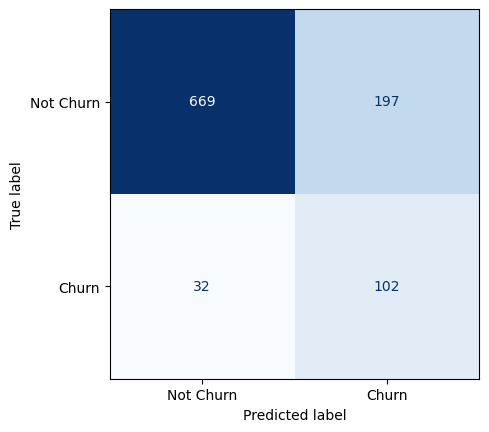

In [16]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(
    pipe,
    X_test,
    y_test,
    display_labels=["Not Churn", "Churn"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
);

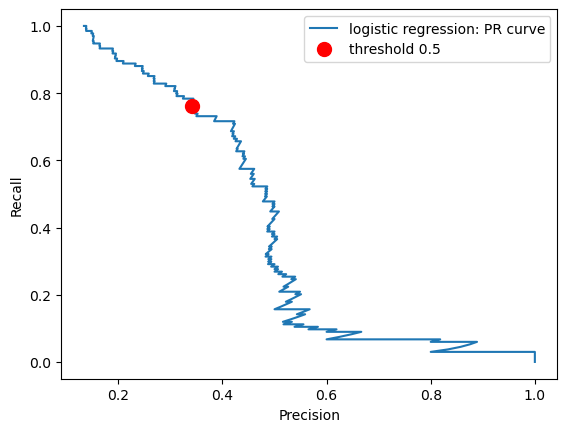

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, pipe.predict_proba(X_test)[:, 1]
)

plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, pipe.predict(X_test)),
    recall_score(y_test, pipe.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [20]:
from sklearn.metrics import average_precision_score

ap_lr = average_precision_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("Average precision of logistic regression: {:.3f}".format(ap_lr))

Average precision of logistic regression: 0.456


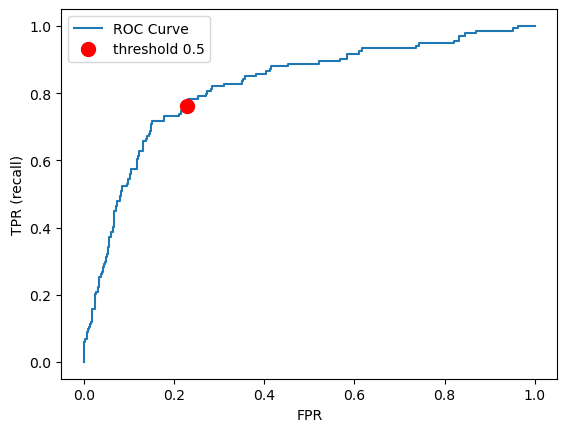

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [22]:
from sklearn.metrics import roc_auc_score

roc_lr = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
print("AUC for logistic regression: {:.3f}".format(roc_lr))

AUC for logistic regression: 0.823


An AUC of 0.823, like in this case, means that there is a 82.3% chance that a a randomly picked positive point (`churn` is True) has a higher score than a randomly picked point from the negative class (`churn` is False).

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [23]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:4}

**Your tasks:**

1. Split the data into train (75%) and test (25%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` to train and test splits. 

In [24]:
train_df, test_df = train_test_split(housing_df, test_size=0.25, random_state=123)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 19995 to 19966
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       15480 non-null  float64
 1   HouseAge     15480 non-null  float64
 2   AveRooms     15480 non-null  float64
 3   AveBedrms    15480 non-null  float64
 4   Population   15480 non-null  float64
 5   AveOccup     15480 non-null  float64
 6   Latitude     15480 non-null  float64
 7   Longitude    15480 non-null  float64
 8   MedHouseVal  15480 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [25]:
train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,3.875935,28.550000,5.421818,1.095860,1437.431137,3.073942,35.626601,-119.568380,2.074085
std,1.900729,12.546577,2.519280,0.492851,1131.575270,10.971330,2.135537,2.001982,1.156051
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.562500,18.000000,4.433750,1.005778,791.000000,2.429227,33.930000,-121.800000,1.203000
50%,3.534300,29.000000,5.228714,1.048412,1173.000000,2.815468,34.250000,-118.490000,1.805000
75%,4.750375,37.000000,6.047297,1.099043,1742.000000,3.278071,37.710000,-118.010000,2.655000
max,15.000100,52.000000,141.909091,34.066667,28566.000000,1243.333333,41.950000,-114.310000,5.000010


Yes, we need to apply standardisation transformation on all the features as all there ranges are different.

In [26]:
numeric_feats = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population",
                 "AveOccup", "Latitude", "Longitude"]
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # scaling on numeric features
)

In [27]:
X_train = train_df.drop(columns=["MedHouseVal"])
X_test = test_df.drop(columns=["MedHouseVal"])

y_train = train_df["MedHouseVal"]
y_test = test_df["MedHouseVal"]

<br><br>

### 3.2 Baseline: Linear Regression 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `sklearn.linear_model.LinearRegression` with default scoring. 
2. What metric is used for scoring by default? 

In [28]:
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(
    ct, 
    LinearRegression()
)

scores = cross_validate(
    pipe, X_train, y_train, return_train_score=True
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.032879,0.004334,0.608602,0.603298
1,0.011565,0.003267,0.599240,0.607080
2,0.010966,0.003117,0.616816,0.602606
3,0.010131,0.003919,0.592949,0.607928
4,0.010218,0.003155,0.015128,0.612855


By default, the metric that is used for scoring by default is $R^2$.

<br><br>

### 3.3 Random Forest Regressor
rubric={points:7}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for two model (`models`) and five evaluation metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [29]:
models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "neg_mean_absolute_percentage_error": "neg_mean_absolute_percentage_error",
}

In [30]:
for model in models.values():
    pipe = make_pipeline(ct, model)
    for scores_type in score_types_reg.values():
        scores = cross_validate(
            pipe, X_train, y_train, return_train_score=True, scoring=scores_type
        )
        results = pd.DataFrame(scores)
        print("Results for ", model, " with score type as: ", scores_type, "\n")
        display(results)

Results for  Ridge()  with score type as:  neg_mean_squared_error 



,fit_time,score_time,test_score,train_score
0,0.016777,0.003848,-0.549963,-0.523218
1,0.007795,0.003738,-0.539582,-0.524089
2,0.006890,0.002831,-0.509989,-0.531546
3,0.007799,0.003101,-0.538532,-0.525259
4,0.006694,0.002783,-1.255748,-0.523310


Results for  Ridge()  with score type as:  neg_root_mean_squared_error 



,fit_time,score_time,test_score,train_score
0,0.007326,0.003092,-0.741595,-0.723338
1,0.006732,0.002878,-0.734563,-0.723940
2,0.006967,0.002807,-0.714135,-0.729072
3,0.006605,0.002845,-0.733847,-0.724748
4,0.007098,0.003073,-1.120602,-0.723402


Results for  Ridge()  with score type as:  neg_mean_absolute_error 



,fit_time,score_time,test_score,train_score
0,0.007775,0.003680,-0.539838,-0.529527
1,0.007711,0.006024,-0.544145,-0.530660
2,0.007500,0.003392,-0.522755,-0.536714
3,0.008485,0.003232,-0.536827,-0.532926
4,0.023441,0.003860,-0.536979,-0.529657


Results for  Ridge()  with score type as:  r2 



,fit_time,score_time,test_score,train_score
0,0.008440,0.003447,0.608633,0.603297
1,0.007597,0.003357,0.599232,0.607080
2,0.007260,0.003240,0.616812,0.602606
3,0.007524,0.003041,0.592940,0.607928
4,0.007205,0.003116,0.014994,0.612855


Results for  Ridge()  with score type as:  neg_mean_absolute_percentage_error 



,fit_time,score_time,test_score,train_score
0,0.007665,0.318781,-0.321621,-0.315332
1,0.007955,0.003116,-0.319187,-0.317532
2,0.006262,0.002462,-0.313360,-0.319989
3,0.005663,0.002340,-0.322003,-0.316455
4,0.005915,0.002578,-0.320155,-0.315432


Results for  RandomForestRegressor()  with score type as:  neg_mean_squared_error 



,fit_time,score_time,test_score,train_score
0,6.190015,0.081424,-0.257143,-0.038640
1,5.945664,0.073511,-0.274083,-0.037498
2,5.699073,0.077862,-0.256065,-0.038962
3,5.720496,0.072452,-0.285462,-0.037221
4,5.652091,0.071888,-0.268769,-0.036666


Results for  RandomForestRegressor()  with score type as:  neg_root_mean_squared_error 



,fit_time,score_time,test_score,train_score
0,5.709693,0.077102,-0.504203,-0.196234
1,5.772643,0.083130,-0.524668,-0.192854
2,5.680743,0.078492,-0.504580,-0.197646
3,5.674129,0.072748,-0.532469,-0.193636
4,5.668086,0.074062,-0.517288,-0.193299


Results for  RandomForestRegressor()  with score type as:  neg_mean_absolute_error 



,fit_time,score_time,test_score,train_score
0,5.686303,0.074818,-0.339012,-0.128679
1,5.694218,0.084403,-0.338792,-0.125418
2,5.665700,0.072792,-0.329974,-0.127427
3,5.695122,0.071920,-0.347862,-0.125749
4,5.658045,0.071663,-0.337942,-0.124569


Results for  RandomForestRegressor()  with score type as:  r2 



,fit_time,score_time,test_score,train_score
0,5.693113,0.071482,0.817727,0.970342
1,5.702829,0.072094,0.797479,0.972251
2,5.857934,0.075505,0.810257,0.971220
3,5.763560,0.071073,0.784558,0.972634
4,5.668028,0.073590,0.786639,0.973348


Results for  RandomForestRegressor()  with score type as:  neg_mean_absolute_percentage_error 



,fit_time,score_time,test_score,train_score
0,5.691416,0.092765,-0.196411,-0.072903
1,5.697354,0.071762,-0.184333,-0.071072
2,5.681242,0.074889,-0.187550,-0.072085
3,6.382404,0.500414,-0.195477,-0.070312
4,6.035658,0.072565,-0.191457,-0.070094


`RandomForestRegressor()` shows results that beat the baseline of `Ridge()` when compared using all the metrics: neg_mean_squared_error, neg_root_mean_squared_error, neg_mean_absolute_error, r2, neg_mean_absolute_percentage_error. 

<br><br>

### 3.4 Hyperparameter optimization 
rubric={points:1}

1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose `neg_mean_absolute_percentage_error` as the HParam optimization metric.

2. What was the best `alpha` hyper-parameter found?

In [31]:
from scipy.stats import loguniform

pipe = make_pipeline(ct, Ridge())

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, 
    n_jobs=-1, n_iter=10, cv=5, random_state=123, 
    scoring='neg_mean_absolute_percentage_error'
)

random_search.fit(X_train, y_train)

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_ridge__alpha",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10
mean_test_score,-0.319137,-0.319164,-0.319177,-0.319256,-0.319267,-0.319271,-0.319273,-0.319274,-0.319275,-0.334004
param_ridge__alpha,20.740242,15.094374,12.852228,2.031836,0.768407,0.345652,0.225271,0.0521,0.022967,766.628906


The best `alpha` was found to be `20.740242`

<br><br>

### 3.5 Test results
rubric={points:4}

**Your tasks:**

Test the best model (from 3.4) on the test set based on the `neg_mean_absolute_percentage_error` score.

In [32]:
pipe = make_pipeline(ct, Ridge(alpha=20.740242))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6078321698443169

<br><br>

### 3.6 Model interpretation  
rubric={points:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Explore coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: 
   - features 
   - coefficients
2. Increasing which feature values would result in higher housing price? 

In [33]:
coeffs = pipe.named_steps["ridge"].coef_
pd.DataFrame(data=coeffs, index= X_train.columns.values, columns=["Coefficients"])

,Coefficients
MedInc,0.834501
HouseAge,0.119523
AveRooms,-0.271909
AveBedrms,0.308059
Population,-0.002577
AveOccup,-0.042213
Latitude,-0.878016
Longitude,-0.847449


Increasing the MedInc, HouseAge and AveRooms will result in higher housing price.

<br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 